In [1]:
import numpy as np
import nibabel as nib
import os
import matplotlib.pyplot as plt
import pandas as pd
from convert_fm import convert_img_ppm_to_Hz_data, convert_ppm_data_to_Hz_data
from demod import demod_pls
from extract_metric import extract_metrics

# <span style="color:orange"> *db0_033 processing* </span> 

Due to the FOV and ROMEO cropping some of the bottom slices, we should only extract metric from C2 or C3 until T7 (14)

In [4]:
# Simulation folders and files
path_to_fms = "E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/fms" # 4 Simulations
path_to_dmod_mask = "E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz" # 4 Simulations (also cord mask)
path_to_labeled_cord = "E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz" # 4 Simulations
path_to_metrics = "E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D4_metrics" # 4 Simulations
path_to_dmod_folder = "E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/V1_dmod_sim" # 4 Simulations

## Measured B0 - Inspiration & Expiration

### <span style="color:green"> Expiration </span> 

In [2]:
path_to_exp_meas = "E:/msc_data/ismrm_2025/dB0_033_dup1/fm/C1_meas/exp/tests/test1/B0.nii"
path_to_exp_dmod_mask = "E:/msc_data/ismrm_2025/dB0_033_dup1/fm/processing_steps/D1_D2_label_vert/exp/cord_mask.nii.gz"
path_to_exp_metric_mask = "E:/msc_data/ismrm_2025/dB0_033_dup1/fm/processing_steps/D1_D2_label_vert/exp/cord_mask_labeled.nii.gz"

In [3]:
# Load images and get nifti data to manipulate!
exp_B0_meas_img = nib.load(path_to_exp_meas)
exp_B0_meas_data = exp_B0_meas_img.get_fdata()

exp_metric_mask_img = nib.load(path_to_exp_metric_mask)
exp_metric_mask_data = exp_metric_mask_img.get_fdata()

In [4]:
# Work July 7th - retrying everything for this dub
dmod_value_exp = np.mean(exp_B0_meas_data[exp_metric_mask_data == 1])
print("Demodulation value for expiration: ", dmod_value_exp)

Demodulation value for expiration:  260.6165514583544


In [12]:
# Extract metrics, plot and save value
exp_B0_metrics_path =  "E:/msc_data/ismrm_2025/dB0_033_dup1/fm/C1_meas/exp/exp_metrics_july_test.csv"
extract_metrics(path_to_exp_meas, path_to_exp_dmod_mask, path_to_exp_metric_mask, exp_B0_metrics_path, method='wa', vert="4:14")

Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/C1_meas/exp/tests/test1/B0.nii -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/processing_steps/D1_D2_label_vert/exp/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/processing_steps/D1_D2_label_vert/exp/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/C1_meas/exp/exp_metrics_july_test.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/C1_meas/exp/exp_metrics_july_test.csv

Total runtime; 0.383 seconds.



In [6]:
# Load the metrics
exp_B0_metrics_df = pd.read_csv(exp_B0_metrics_path)
exp_B0_metrics = exp_B0_metrics_df['WA()'][::-1]
exp_B0_metrics


10    181.808669
9     234.078980
8     294.024011
7     369.443786
6     405.704963
5     379.206845
4     359.523679
3     367.167140
2     374.285754
1     371.927968
0     352.401951
Name: WA(), dtype: float64

In [13]:
dmod_exp_B0_metrics = exp_B0_metrics - dmod_value_exp
dmod_exp_B0_metrics

10    -78.807882
9     -26.537571
8      33.407460
7     108.827235
6     145.088412
5     118.590294
4      98.907127
3     106.550588
2     113.669203
1     111.311417
0      91.785400
Name: WA(), dtype: float64

In [14]:
central_freq_exp_db33 = 123.249489 # in MHz
gamma_bar = 42.58 # MHz/T
B0 = 3 # [T]
water_Hz_3T = B0 * gamma_bar # This comes from Larmor equation, gyromagnetic ratio in MHz/T
print("Frequency of water at 3T: ", water_Hz_3T, "MHz")

freq_offset_exp =  central_freq_exp_db33 - water_Hz_3T 
print("Frequency adjustment for absolute frequency per voxel: ", freq_offset_exp, "MHz")

Frequency of water at 3T:  127.74 MHz
Frequency adjustment for absolute frequency per voxel:  -4.490510999999998 MHz


In [9]:
# If the central frequency from the scanner is 123.249489 MHz, it meas the B0 strenght we need to simulate is:
B0_used_scanner = central_freq_exp_db33 /gamma_bar

In [9]:
# Lets calculate the frequency offset from "n" pi wraps
n = 2
gamma = gamma_bar*2*np.pi
deltaTE = 5.2-3.27
freq_offset_npi = (central_freq_exp_db33*n*np.pi)/(gamma*deltaTE*1e-3*B0_used_scanner)
print(f"Frequency offset from a {n} pi wrap: ",freq_offset_npi," Hz")

Frequency offset from a 2 pi wrap:  518.1347150259068  Hz


In [15]:
# Import the data:
raw_exp_metrics_path = r"E:\msc_data\ismrm_2025\dB0_033_dup1\fm\C1_meas\exp\raw_exp_metrics.csv"
raw_exp_metrics_csv = pd.read_csv(raw_exp_metrics_path)

raw_exp_metrics= raw_exp_metrics_csv['WA()'][::-1]

raw_exp_metrics 

10    181.808669
9     234.078980
8     294.024011
7     369.443786
6     405.704963
5     379.206845
4     359.523679
3     367.167140
2     374.285754
1     371.927968
0     352.401951
Name: WA(), dtype: float64

### <span style="color:red"> Inspiration </span> 

In [10]:
path_to_insp_meas = "E:/msc_data/ismrm_2025/dB0_033_dup1/fm/C1_meas/insp/tests/test1/B0.nii"
# This don't change:
path_to_insp_dmod_mask = "E:/msc_data/ismrm_2025/dB0_033_dup1/fm/processing_steps/D1_D2_label_vert/insp/cord_mask.nii.gz"
path_to_insp_metric_mask = "E:/msc_data/ismrm_2025/dB0_033_dup1/fm/processing_steps/D1_D2_label_vert/insp/cord_mask_labeled.nii.gz"

In [11]:
# Load images and get nifti data to manipulate!
insp_B0_meas_img = nib.load(path_to_insp_meas)
insp_B0_meas_data = insp_B0_meas_img.get_fdata()

insp_metric_mask_img = nib.load(path_to_insp_metric_mask)
insp_metric_mask_data = insp_metric_mask_img.get_fdata()

In [18]:
# Work July 7th - retrying everything for this dub
dmod_value_insp = np.mean(insp_B0_meas_data[insp_metric_mask_data == 1])
print("Demodulation value for expiration: ", dmod_value_insp)

Demodulation value for expiration:  -302.81905592872096


In [16]:
insp_B0_metrics_path = "E:/msc_data/ismrm_2025/dB0_033_dup1/fm/C1_meas/insp/exp_metrics_july_test.csv"

extract_metrics(path_to_insp_meas, path_to_insp_dmod_mask, path_to_insp_metric_mask, insp_B0_metrics_path, method='wa', vert="4:14")

Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/C1_meas/insp/tests/test1/B0.nii -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/processing_steps/D1_D2_label_vert/insp/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/processing_steps/D1_D2_label_vert/insp/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/C1_meas/insp/exp_metrics_july_test.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/C1_meas/insp/exp_metrics_july_test.csv

Total runtime; 0.435 seconds.



In [20]:
# Load the metrics
insp_B0_metrics_df = pd.read_csv(insp_B0_metrics_path)
insp_B0_metrics = insp_B0_metrics_df['WA()'][::-1]
insp_B0_metrics

10   -368.069584
9    -305.188981
8    -229.622627
7    -146.332100
6    -116.067738
5    -183.757192
4    -229.167591
3    -240.508212
2    -240.673513
1    -239.302442
0    -245.267424
Name: WA(), dtype: float64

In [24]:
dmod_insp_B0_metrics = insp_B0_metrics - dmod_value_insp
dmod_insp_B0_metrics

10    -65.250528
9      -2.369925
8      73.196429
7     156.486956
6     186.751318
5     119.061864
4      73.651465
3      62.310844
2      62.145543
1      63.516614
0      57.551632
Name: WA(), dtype: float64

In [17]:
raw_insp_metrics_path = "E:/msc_data/ismrm_2025/dB0_033_dup1/fm/C1_meas/insp/raw_insp_metrics.csv"

In [12]:
raw_insp_metrics_df = pd.read_csv(raw_insp_metrics_path)
raw_insp_metrics = raw_insp_metrics_df['WA()'][::-1]

raw_insp_metrics

10   -368.069584
9    -305.188981
8    -229.622627
7    -146.332100
6    -116.067738
5    -183.757192
4    -229.167591
3    -240.508212
2    -240.673513
1    -239.302442
0    -245.267424
Name: WA(), dtype: float64

In [16]:
two_pi_offset_corrected_insp = raw_insp_metrics + freq_offset_npi

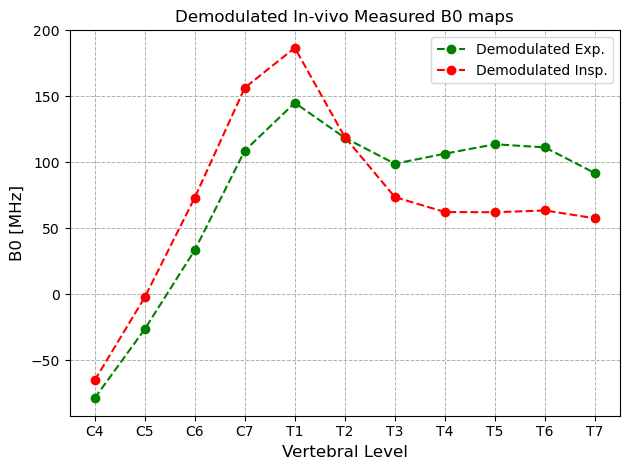

In [33]:
# Correct for phase wraps the Expiration:
#exp_corrected_metrics = raw_exp_metrics - np.abs(freq_offset_npi)
vertebrae_levels = [ 'C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7'] # From 4 to 14
plt.plot(vertebrae_levels, dmod_exp_B0_metrics, marker = 'o', linestyle = '--', label = "Demodulated Exp.", color = "green")
plt.plot(vertebrae_levels, dmod_insp_B0_metrics, marker = 'o', linestyle = '--', label = "Demodulated Insp.", color = "red")

plt.title("Demodulated In-vivo Measured B0 maps")
plt.xlabel('Vertebral Level', fontsize=12)
plt.ylabel('B0 [MHz]', fontsize=12)
plt.legend()
# Customize grid and display
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.tight_layout()

# Show the plot
plt.show()

### <span style="color:#C28AD1"> Average Insp and Exp </span> 

In [31]:
avg_demod_respiration = (dmod_exp_B0_metrics + dmod_insp_B0_metrics )/2
avg_demod_respiration

10    -72.029205
9     -14.453748
8      53.301945
7     132.657095
6     165.919865
5     118.826079
4      86.279296
3      84.430716
2      87.907373
1      87.414016
0      74.668516
Name: WA(), dtype: float64

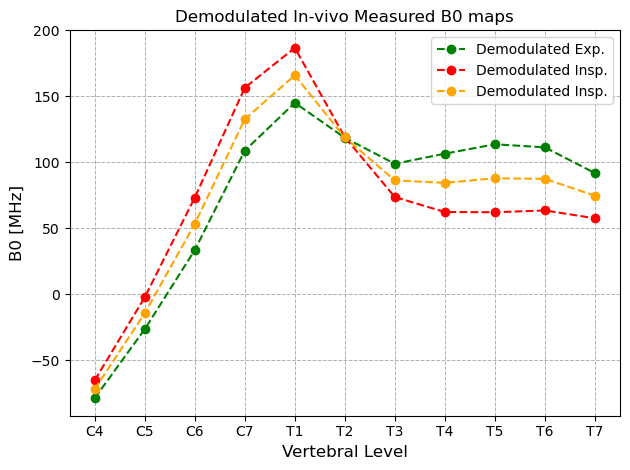

In [34]:
# Correct for phase wraps the Expiration:
#exp_corrected_metrics = raw_exp_metrics - np.abs(freq_offset_npi)
vertebrae_levels = [ 'C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7'] # From 4 to 14
plt.plot(vertebrae_levels, dmod_exp_B0_metrics, marker = 'o', linestyle = '--', label = "Demodulated Exp.", color = "green")
plt.plot(vertebrae_levels, dmod_insp_B0_metrics, marker = 'o', linestyle = '--', label = "Demodulated Insp.", color = "red")
# After you have the average done:
plt.plot(vertebrae_levels, avg_demod_respiration, marker = 'o', linestyle = '--', label = "Demodulated Insp.", color = "orange")

plt.title("Demodulated In-vivo Measured B0 maps")
plt.xlabel('Vertebral Level', fontsize=12)
plt.ylabel('B0 [MHz]', fontsize=12)
plt.legend()
# Customize grid and display
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.tight_layout()

# Show the plot
plt.show()

In [35]:
# Now we save this to load the average to load for susceptibility fitting
avg_demod_respiration.to_csv("E:/msc_data/ismrm_2025/dB0_033_dup1/fm/C_dmod_meas/dmod_avg_respiration.csv" , index = False, header = True)

### <span style="color:#81DDE7"> Simualted FM loading, calculations, extract metric and plot!  </span> 
Here we bring the data from the simulation with an initial assumption of chi value for trachea and lung </br>
This helps confirm the shape of the curves and the dimension of the graphs

In [22]:
dmod_mask_img = nib.load(path_to_dmod_mask)
dmod_mask_data = dmod_mask_img.get_fdata()

metric_mask_img = nib.load(path_to_labeled_cord)
metric_mask_data = metric_mask_img.get_fdata()

In [23]:
path_to_fms

'E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/fms'

In theory, the simulated fieldmaps in PPM use susceptibility distributions referenced to either free space (0) or relative to other values. If it is the same subject, changing the reference should not change the fm values in ppm.

In [23]:
fm_ppm_ref_zero_img = nib.load(os.path.join(path_to_fms,"dB0_033_sim_fm_ppm.nii.gz"))
fm_ppm_ref_zero_data = fm_ppm_ref_zero_img.get_fdata()

#fmref_zero_Hz_ = convert_ppm_data_to_Hz_data(fm_ppm_ref_zero_data,B0_used_scanner)
# ## # # ### ##  ###  ## ### # # # # #### 
fm_ppm_ref_h20_img = nib.load(os.path.join(path_to_fms,"custom_dmod_water_fm_ppm.nii.gz"))
fm_ppm_ref_h20_data = fm_ppm_ref_h20_img.get_fdata()


In [24]:
# Extracting metrics faster through this code (not using extract_metrics)
start_vert = 4
end_vert = 14
selected_range_mask = (metric_mask_data >= start_vert) & (metric_mask_data <= end_vert)

level_means_ref_zero = {}
level_means_ref_h20 = {}

for level in range(start_vert, end_vert + 1):
    level_mask = metric_mask_data == level
    level_means_ref_zero[level] = np.mean(fm_ppm_ref_zero_data[level_mask])
    level_means_ref_h20[level] = np.mean(fm_ppm_ref_h20_data[level_mask])

In [25]:
list_c4_t7_ref_zero =  []

for key, value in level_means_ref_zero.items():
    print(key,value)
    list_c4_t7_ref_zero.append(value)

4 -3.5799368440219044
5 -3.4931521458916452
6 -3.2764471133429227
7 -2.9993050221288415
8 -2.9182237643342317
9 -3.1384212111863565
10 -3.26151118486044
11 -3.2208164853089354
12 -3.162387757876323
13 -3.2214410207454205
14 -3.24259450512859


In [26]:
list_c4_t7_ref_h20 =  []

for key, value in level_means_ref_h20.items():
    print(key,value)
    list_c4_t7_ref_h20.append(value)


4 2.443396489331677
5 2.5301811881670253
6 2.7468862205653206
7 3.0240283106502734
8 3.1051095705218996
9 2.884912125238283
10 2.7618221489993378
11 2.802516845739256
12 2.860945573823025
13 2.801892314102317
14 2.7807388312903494


In [32]:
list_c4_t7_ref_zero_Hz = [i*central_freq_exp_db33 for i in list_c4_t7_ref_zero]
list_c4_t7_ref_h20_Hz = [i*central_freq_exp_db33 for i in list_c4_t7_ref_h20]

In [36]:
list_c4_t7_ref_h20_Hz

[np.float64(301.1473687345231),
 np.float64(311.8435385189987),
 np.float64(338.55232302581703),
 np.float64(372.7099440091794),
 np.float64(382.70316785583356),
 np.float64(355.5639452455224),
 np.float64(340.3931685730502),
 np.float64(345.40876915125517),
 np.float64(352.6100800304996),
 np.float64(345.3317959461381),
 np.float64(342.72463999899276)]

In [33]:
list_c4_t7_ref_zero_Hz

[np.float64(-441.2253866779724),
 np.float64(-430.5292169803987),
 np.float64(-403.8204324550403),
 np.float64(-369.6628113325134),
 np.float64(-359.6695877418505),
 np.float64(-386.8088105454795),
 np.float64(-401.9795869018337),
 np.float64(-396.9639859771023),
 np.float64(-389.7626751781125),
 np.float64(-397.04095965051147),
 np.float64(-399.64811579130657)]

What we see here is that the values are different but are the deltas different?

In [27]:
list_c4_t7_ref_zero[1] - list_c4_t7_ref_zero[0]

np.float64(0.08678469813025913)

In [28]:
list_c4_t7_ref_h20[1] - list_c4_t7_ref_h20[0]

np.float64(0.08678469883534845)

So, the deltas seem to be the same but the magnitude won't be the same
It makes sense to use the susceptibility distribution that is relative to free space, that's most likely the one that could be understood is used when we get into the scanner, i.e., our "susceptibility distributions" are not referenced to water or to bone, this is something we change for reporting values.

In [29]:
curr_fm = nib.load(os.path.join(path_to_fms,"custom_dmod_water_fm_ppm.nii.gz"))
curr_fm_data = curr_fm.get_fdata()

In [31]:
raw_fm_Hz = convert_ppm_data_to_Hz_data(curr_fm_data,B0_used_scanner)

rawSimHz_save_path = r"E:\msc_data\ismrm_2025\dB0_033_dup1\fm\sim/raw_sim_fm.nii.gz"

raw_sim_fm_img = nib.Nifti1Image(raw_fm_Hz, affine = curr_fm.affine)

nib.save(raw_sim_fm_img, rawSimHz_save_path)

outfn_raw_fm_sim = os.path.join(path_to_metrics,"initial_raw_sim_fm.csv")

extract_metrics(rawSimHz_save_path, path_to_dmod_mask, path_to_labeled_cord, outfn_raw_fm_sim, method='wa', vert="4:14")

Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\sim/raw_sim_fm.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D4_metrics\initial_raw_sim_fm.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D4_metrics\initial_raw_sim_fm.csv




In [37]:
central_freq_exp_db33

123.249489

In [38]:
# The equations show that to get the simulation to be comparable with the raw measured fieldmaps we just need to:
# 1st. Perform the FM calculation which will give us the fieldmap in PPM
# 2nd. We multiply by the central frequency.
test_raw_sim1 = [i*central_freq_exp_db33 for i in list_c4_t7_ref_zero]
test_raw_sim1

[np.float64(-441.2253866779724),
 np.float64(-430.5292169803987),
 np.float64(-403.8204324550403),
 np.float64(-369.6628113325134),
 np.float64(-359.6695877418505),
 np.float64(-386.8088105454795),
 np.float64(-401.9795869018337),
 np.float64(-396.9639859771023),
 np.float64(-389.7626751781125),
 np.float64(-397.04095965051147),
 np.float64(-399.64811579130657)]

In [28]:
path_to_ref_zero_fm_Hz = r"E:\msc_data\ismrm_2025\dB0_033_dup1\fm\sim/raw_sim_fm_ref_zero_Hz.csv"

# Convert to DataFrame
df_raw_sim1 = pd.DataFrame(test_raw_sim1, columns=['WA()'])

# Save to CSV
df_raw_sim1.to_csv(path_to_ref_zero_fm_Hz, index=False, header = True)

In [39]:
# Now we can load this without having to re-do calculations
path_to_ref_zero_fm_Hz = r"E:\msc_data\ismrm_2025\dB0_033_dup1\fm\sim/raw_sim_fm_ref_zero_Hz.csv"

raw_sim_fm_ref_zero_Hz_csv = pd.read_csv(path_to_ref_zero_fm_Hz)
raw_sim_fm_ref_zero_Hz_csv = raw_sim_fm_ref_zero_Hz_csv["WA()"]
raw_sim_fm_ref_zero_Hz_csv

0    -441.225387
1    -430.529217
2    -403.820432
3    -369.662811
4    -359.669588
5    -386.808811
6    -401.979587
7    -396.963986
8    -389.762675
9    -397.040960
10   -399.648116
Name: WA(), dtype: float64

In [40]:
test_raw_sim2 = [i*central_freq_exp_db33 for i in list_c4_t7_ref_h20]
test_raw_sim2

[np.float64(301.1473687345231),
 np.float64(311.8435385189987),
 np.float64(338.55232302581703),
 np.float64(372.7099440091794),
 np.float64(382.70316785583356),
 np.float64(355.5639452455224),
 np.float64(340.3931685730502),
 np.float64(345.40876915125517),
 np.float64(352.6100800304996),
 np.float64(345.3317959461381),
 np.float64(342.72463999899276)]

In [33]:
path_to_ref_h20_fm_Hz = r"E:\msc_data\ismrm_2025\dB0_033_dup1\fm\sim/raw_sim_fm_ref_h20_Hz.csv"

# Convert to DataFrame
df_raw_sim2 = pd.DataFrame(test_raw_sim2, columns=['WA()'])

# Save to CSV
df_raw_sim2.to_csv(path_to_ref_h20_fm_Hz, index=False, header = True)

In [41]:
# Now we can load this without having to re-do calculations
path_to_ref_h20_fm_Hz = r"E:\msc_data\ismrm_2025\dB0_033_dup1\fm\sim/raw_sim_fm_ref_h20_Hz.csv"

raw_sim_fm_ref_h20_Hz_csv = pd.read_csv(path_to_ref_h20_fm_Hz)["WA()"]
raw_sim_fm_ref_h20_Hz_csv

0     301.147369
1     311.843539
2     338.552323
3     372.709944
4     382.703168
5     355.563945
6     340.393169
7     345.408769
8     352.610080
9     345.331796
10    342.724640
Name: WA(), dtype: float64

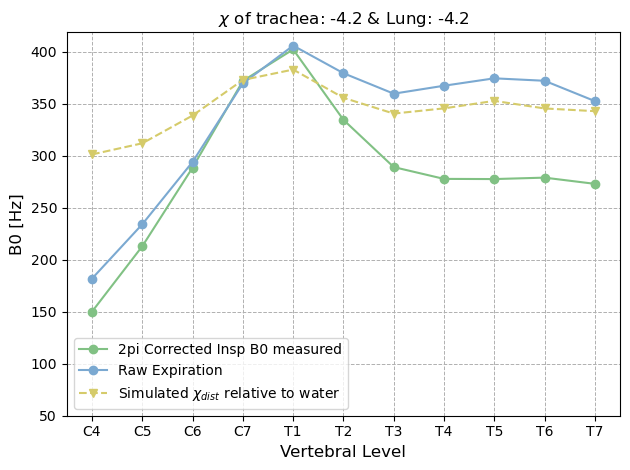

In [50]:
# With that done we can plot them:
vertebrae_levels = ['C4','C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7'] # From 5 to 14
plt.plot(vertebrae_levels, two_pi_offset_corrected_insp, marker = 'o', linestyle = '-', label = "2pi Corrected Insp B0 measured", color = "#81C184")
#plt.plot(vertebrae_levels, raw_exp_metrics, marker = '*', linestyle = '-', label = "Raw Exp B0 measured", color = "#7BA9D1")
plt.plot(vertebrae_levels, raw_exp_metrics, marker = 'o', linestyle = '-', label = f"Raw Expiration", color = "#7BA9D1")
plt.plot(vertebrae_levels, raw_sim_fm_ref_h20_Hz_csv, marker = 'v', linestyle = '--', label = r"Simulated $\chi_{dist}$ relative to water", color = "#D5CB6A")
#plt.plot(vertebrae_levels, raw_sim_fm_ref_zero_Hz_csv, marker = '*', linestyle = '--', label = r"Simulated Absolute $\chi_{dist}$", color = "#D5CB6A")

title = "dB0_033 Simulation vs Measured"
plt.title("$\\chi$ of trachea: -4.2 & Lung: -4.2")
plt.xlabel('Vertebral Level', fontsize=12)
plt.ylabel('B0 [Hz]', fontsize=12)
plt.legend()
# Customize grid and display
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.tight_layout()

yticks = range(50, 450, 50) 
plt.yticks(yticks)

# Show the plot
plt.show()

In [5]:
avg_raw_db0_033_offset_correction =  raw_insp_metrics + exp_corrected_metrics
avg_raw_db0_033_offset_correction

NameError: name 'raw_insp_metrics' is not defined

# <span style="color:#2F67A7"> Testing new demodulation approach* </span> </br>

Done to one subject only to test the hypothesis: </br>
The absolute frequency is: 

$$ f_{abs} = f_{meas} + f_{water} - f_{central}$$

Where the frequency of water depends on the field strength in Tesla and the central frequency is something the scanner sets during load tune-up. The latter can be obtained from the accompanying json sidecar of the echoes.

### <span style="color:green"> Expiration* </span> </br>
The difference is now we need to get the central frequency value from the json sidecars </br>
For expiration: 123.249489 Hz

The frequency shift of an MR image is given by: deltaF / F0 </br>
F0 is the resonating frequency of spins at the defined Tesla </br>
Recall the gyromagnetic ratio in [Hz/Tesla] is 42.58 1e6 for Hydrogen nuclei </br>
If you don't use the 1e6 in calculations, the final value will be in [ppm]

In [1]:
# For example, at 1.5 T 1000 Hz difference [-500, 500] is equal to:
#500 / (1.5 * 42.58)
# in [ppm]
central_freq_exp = 123.249489 # in MHz
gamma_bar = 42.58 # MHz/T
water_Hz_3T = 3 * 42.58 # This comes from Larmor equation, gyromagnetic ratio in MHz/T
print("Frequency of water at 3T: ", water_Hz_3T, "MHz")

freq_offset_exp =  central_freq_exp - water_Hz_3T 
print("Frequency adjustment for absolute frequency per voxel: ", freq_offset_exp, "MHz")

Frequency of water at 3T:  127.74 MHz
Frequency adjustment for absolute frequency per voxel:  -4.490510999999998 MHz


In [3]:
B0_scanner = central_freq_exp/gamma_bar
print("B0 used this scan: ", B0_scanner, "T")

B0 used this scan:  2.8945394316580555 T


In [63]:
# We need to apply this to the measured Expiration values
# Lets see what the raw values look like before demodulation
raw_exp_B0_metrics_path = "E:/msc_data/ismrm_2025/dB0_033_dup1/fm/C1_meas/exp/raw_exp_metrics.csv"
extract_metrics(path_to_exp_meas, path_to_exp_dmod_mask, path_to_exp_metric_mask, raw_exp_B0_metrics_path, method='wa', vert="4:14")

Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/C1_meas/exp/tests/test1/B0.nii -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/processing_steps/D1_D2_label_vert/exp/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/processing_steps/D1_D2_label_vert/exp/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/C1_meas/exp/raw_exp_metrics.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/C1_meas/exp/raw_exp_metrics.csv




With this, the simulation of the fieldmap needs to have values of susceptibility referenced to water. </br>
This can be done manually with the following cell of you can just load your own </br>
Tissue2MR property already has enabled a "reference" flag that enables you to change the reference value for all the susceptibility values

### Manual demodulation of chimap (skip)

In [44]:
# Load chi map
og_chimap = nib.load(r"E:\msc_data\ismrm_2025\dB0_033_dup1\fm\sim\B1_chi_maps/dB0_033_mod0.nii.gz")
og_chimap_data = og_chimap.get_fdata()
water_ppm = -9.035
water_sim_dmod = og_chimap_data - (water_ppm)

#Now simulate fieldmap and load
water_sim_dmod_chimap = nib.Nifti1Image(water_sim_dmod, affine = og_chimap.affine)
outpath = r"E:\msc_data\ismrm_2025\dB0_033_dup1\fm\sim\B1_chi_maps/dB0_033_dmod_water.nii.gz"
nib.save(water_sim_dmod_chimap, outpath)

In [ ]:
# Load it
path_to_dmod_sim_water = r"E:\msc_data\ismrm_2025\dB0_033_dup1\fm\sim\B1_chi_maps/custom_dmod_water_fm_ppm.nii.gz"
dmod_sim_water_fm_ppm = nib.load(path_to_dmod_sim_water)
dmod_sim_water_fm_Hz = dmod_sim_water_fm_ppm * 3 * 42.58

### Loading Chi map with susceptibility referenced to water

In [23]:
# Do it on your own terminal and just load
path_to_2nd_water_dmod_fm = r"E:\msc_data\ismrm_2025\dB0_033_dup1\anat\t1w\segmentations\merging_outputs\output/custom_dmod_water_fm_ppm.nii.gz"
path_to_water_dmod_test_results1 = "E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D4_metrics/water_dmod_test1.csv"

In [54]:
extract_metrics(path_to_2nd_water_dmod_fm, path_to_dmod_mask, path_to_labeled_cord, path_to_water_dmod_test_results1, method='wa', vert="4:14")

Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\anat\t1w\segmentations\merging_outputs\output/custom_dmod_water_fm_ppm.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D4_metrics/water_dmod_test1.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D4_metrics/water_dmod_test1.csv




In [30]:
# Import the data:
dmod_water_results = pd.read_csv(path_to_water_dmod_test_results1)

dmod_water_results_csv = dmod_water_results['WA()']
dmod_water_results_csv = dmod_water_results_csv[::-1]

dmod_water_results_Hz = dmod_water_results_csv*3*42.58

In [31]:
dmod_water_results_Hz

10    312.145353
9     323.201694
8     350.994819
7     386.081746
6     396.752853
5     368.322464
4     352.905186
3     357.780743
2     365.425772
1     357.945871
0     355.298681
Name: WA(), dtype: float64